In [1]:
import pandas as pd

# Project 2: Predicting Authorship of the Disputed Federalist Papers

The Federalist Papers are a collection of 85 essays written by James Madison, Alexander Hamilton, and John Jay under the collective pseudonym "Publius" to promote the ratification of the United States Constitution.

<img src="images\the_federalist_papers.jpg" width=200 height=50 />

Authorship of most of the papers were revealed some years later by Hamilton, though his claim to authorshipt of 12 papers were disputed for nearly 200 years (studies generally agree that the disputed essays were written by James Madison.)

| Author | Papers |
| :- | -: | 
| Jay | 2, 3, 4, 5, 64
| Madison | 10, 14, 37-48
| Hamilton | 1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21-36, 59, 60, 61, 65-85
| Hamilton and Madison | 18, 19, 20
| Disputed | 49-58, 62, 63

The goal of this project is to train a classifier that predicts the author of the disputed papers.

Table of Contents

- [Getting and processing the data](#1.-Getting-and-processing-the-data)
- [Logistic Regression](#2.-Logistic-Regression)
- [Naive Bayes](#3.-Naive-Bayes-Classification)
- [Disputed Federalist Papers](#4.-Disputed-Federalist-Papers)
- [How does Naive Bayes choose between Hamilton and Madison](#5.-How-does-Naive-Bayes-choose-between-Hamilton-and-Madison)
- [Parameter tuning using grid search](#6.-Parameter-tuning-using-grid-search)
- [Data Visualization](#7.-Data-visualization)

## 1. Getting and processing the data

Retrieve an electronic version of the Federalist Papers from the [Gutenberg project](http://www.gutenberg.org/). Use the search facility to search for the Federalist Papers. Several versions are available. 
We'll use the plain text version [1408-8.txt](http://www.gutenberg.org/cache/epub/1404/pg1404.txt)

First, we'll build a dictionary that identifies the author of each Federalist paper. We'll use the phrase To the People of the state of New York to identify the beginning of a paper, and the word PUBLIUS to identify the end of a paper (The word PUBLIUS marks the end of all papers except 37; we'll need to insert PUBLIUS at the end of Paper 37 manually).

In [2]:
from re import match

In [3]:
path = 'Data/papers.txt'
Fed_dict = {}
opening = 'To the People of the State of New York'
closing = 'PUBLIUS'

counter = 0
paper = ''

# build a dictionary with the Federalist papers 
with open(path) as f:
    for string in f: #  iterate over the lines of the txt file
        if match(opening, string):
            paper = '' # initialize Federalist Paper as an empty string
            counter += 1 # increase counter
        paper = paper+' '+string.replace('\n','') # remove end of line simbol \n; append new line; 
        if match(closing, string):
            Fed_dict[counter]=paper # done

In [4]:
len(Fed_dict)

85

In [5]:
# put the Federalist Papers into a DataFrame
papers = pd.DataFrame.from_dict(Fed_dict, orient='index',columns=['paper'])
papers.head(5)

,paper
1,To the People of the State of New York: AFTE...
2,To the People of the State of New York: WHEN...
3,To the People of the State of New York: IT I...
4,To the People of the State of New York: MY L...
5,To the People of the State of New York: QUEE...


In [6]:
# authorship function
def author(paper_num):
    'it returns the author of a Federalist Paper'
    # papers authored by Jay:
    Jay_list = [2,3,4,5,64]
    # papers authored by Madison:
    Madison_list = [10,14]+list(range(37,49))
    # papers authored by Hamilton
    Hamilton_list = [1,6,7,8,9,11,12,13,15,16,17]+list(range(21,37))+[59,60,61]+list(range(65,86))
    # papers authored by Hamilton+Madison
    Hamilton_Madison_list = [18,19,20]
    # disputed papers
    disputed_list = list(range(49,59))+[62,63]
    if paper_num in Jay_list:
        return 'Jay'
    elif paper_num in Hamilton_list:
        return 'Hamilton'
    elif paper_num in Madison_list:
        return 'Madison'
    elif paper_num in Hamilton_Madison_list:
        return 'Hamilton+Madison'
    elif paper_num in disputed_list:
        return 'Disputed'

In [7]:
# add column author to DataFrame
papers['author'] = papers.index.map(author)
papers.head(5)

,paper,author
1,To the People of the State of New York: AFTE...,Hamilton
2,To the People of the State of New York: WHEN...,Jay
3,To the People of the State of New York: IT I...,Jay
4,To the People of the State of New York: MY L...,Jay
5,To the People of the State of New York: QUEE...,Jay


In [8]:
papers.author.value_counts()

Hamilton            51
Madison             14
Disputed            12
Jay                  5
Hamilton+Madison     3
Name: author, dtype: int64

**Step 1:** train/test split

In [9]:
papers_train = papers[papers.author.isin(['Hamilton','Madison','Jay'])]
papers_test = papers[papers.author=='Disputed']

In [10]:
len(papers_train), len(papers_test)

(70, 12)

**Step 2:** extract feature matrix and target vector

In [11]:
X_train = papers_train.paper
y_train = papers_train.author

In [12]:
X_test = papers_test.paper

**Step 3:** CountVectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english')

In [14]:
# learn training data vocabulary
vect.fit(X_train)
# create document-term matrix
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

## 2. Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter=2000)

log_clf.fit(X_train_dtm,y_train)

LogisticRegression(max_iter=2000)

**Model evaluation**

Problem: we don't have labels for the test set

**Option 1** (not recommended): train and test on the same set

In [16]:
y_train_pred = log_clf.predict(X_train_dtm) 

In [17]:
from sklearn import metrics
metrics.confusion_matrix(y_train,y_train_pred)

array([[51,  0,  0],
       [ 0,  5,  0],
       [ 0,  0, 14]], dtype=int64)

In [18]:
metrics.accuracy_score(y_train,y_train_pred)

1.0

The prediction function has an accuracy rate of 1.

**Option 2** (recommended): use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_clf,X_train_dtm,y_train,cv=4,scoring='accuracy') # we'll use a small number of folds (cv)
scores

array([0.72222222, 0.88888889, 0.88235294, 0.58823529])

## 3. Naive Bayes Classification

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

nb_clf.fit(X_train_dtm,y_train)

MultinomialNB()

**Model evaluation**

In [21]:
y_train_pred = nb_clf.predict(X_train_dtm) 

In [22]:
# option 1
from sklearn import metrics
metrics.confusion_matrix(y_train,y_train_pred)

array([[51,  0,  0],
       [ 0,  5,  0],
       [ 0,  0, 14]], dtype=int64)

In [23]:
metrics.accuracy_score(y_train,y_train_pred)

1.0

In [24]:
# option 2
scores = cross_val_score(nb_clf,X_train_dtm,y_train,cv=4,scoring='accuracy') # we'll use a small number of folds (cv)
scores

array([0.72222222, 0.77777778, 0.76470588, 0.76470588])

In [25]:
scores.mean()

0.7573529411764706

## 4. Disputed Federalist Papers

In [26]:
# logistic regression prediction
y_test_pred = log_clf.predict(X_test_dtm)
y_test_pred

array(['Hamilton', 'Hamilton', 'Madison', 'Hamilton', 'Hamilton',
       'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton',
       'Madison', 'Madison'], dtype=object)

In [27]:
# naive Bayes prediction
y_test_pred = nb_clf.predict(X_test_dtm)
y_test_pred

array(['Hamilton', 'Madison', 'Madison', 'Hamilton', 'Hamilton',
       'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton',
       'Hamilton', 'Hamilton'], dtype='<U8')

## 5. How does Naive Bayes choose between Hamilton and Madison

In [28]:
# store the vocabulary of X_train
X_train_words = vect.get_feature_names()

In [29]:
len(X_train_words)

7732

In [30]:
# examine the first 50 words
print(X_train_words[:50])

['000', '10', '11', '1685', '1688', '1706', '1774', '1783', '1784', '1786', '1787', '1808', '195', '1st', '2d', '30', '3d', '4th', '5th', 'abandon', 'abandoned', 'abandoning', 'abate', 'abetted', 'abilities', 'ability', 'able', 'ablest', 'abolish', 'abolished', 'abolishing', 'abolition', 'abortive', 'abounding', 'abounds', 'abridge', 'abridged', 'abridgements', 'abridging', 'abridgment', 'abroad', 'abrogate', 'abrogating', 'absence', 'absolute', 'absolutely', 'absolves', 'absorb', 'absorbed', 'abstain']


In [31]:
# examine the last 50 words
print(X_train_words[-50:])

['witnesses', 'witty', 'wolsey', 'woman', 'womb', 'won', 'wonder', 'wondered', 'wonderful', 'wood', 'word', 'words', 'work', 'workings', 'works', 'world', 'worn', 'worse', 'worst', 'worthy', 'wound', 'wounded', 'wreaked', 'wreck', 'wretched', 'writ', 'write', 'writer', 'writers', 'writing', 'writings', 'written', 'wrong', 'wrought', 'wyoming', 'xiv', 'yards', 'year', 'years', 'yeomanry', 'yes', 'yield', 'yielding', 'yoke', 'yokes', 'york', 'young', 'zaleucus', 'zeal', 'zealous']


In [32]:
# Naive Bayes counts the number of times each word appears in each class
nb_clf.feature_count_

array([[ 2.,  1.,  1., ...,  0., 12.,  6.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  9.,  2.]])

In [33]:
# rows represent classes (Hamilton, Madison, Jay), columns represent words
nb_clf.feature_count_.shape

(3, 7732)

In [34]:
nb_clf.classes_

array(['Hamilton', 'Jay', 'Madison'], dtype='<U8')

In [35]:
# number of times each word appears across all Hamilton's papers
Hamilton_word_count = nb_clf.feature_count_[0,:]
# number of times each word appears across all Madison's papers
Madison_word_count = nb_clf.feature_count_[2,:]

In [36]:
# create a DataFrame of words with their separate Hamilton and Madison counts
words = pd.DataFrame({'word' : X_train_words, 'Hamilton' : Hamilton_word_count, 'Madison' : Madison_word_count}).set_index('word')
words.head()

,Hamilton,Madison
word,,
000,2.0,0.0
10,1.0,0.0
11,1.0,0.0
1685,0.0,0.0
1688,2.0,0.0


In [37]:
# examine 5 random DataFrame rows
words.sample(5)

,Hamilton,Madison
word,,
parliament,9.0,1.0
deriving,1.0,2.0
civilized,1.0,1.0
distinguishing,2.0,0.0
jointly,1.0,0.0


In [38]:
# add 1 to Hamilton and Madison counts to avoid dividing by 0
words.Hamilton = words.Hamilton+1
words.Madison = words.Madison+1

In [39]:
# convert the Hamilton and Madison counts into frequencies
words.Hamilton = words.Hamilton/words.Hamilton.sum()
words.Madison = words.Madison/words.Madison.sum()

In [40]:
words.sample(5)

,Hamilton,Madison
word,,
campaigns,0.000038,0.000043
opposes,0.000019,0.000043
malcontents,0.000038,0.000043
scotland,0.000038,0.000043
application,0.000192,0.000171


In [41]:
# calculate the ration of Hamilton-to-Madison and Madison-to-Hamilton for each word
words['Hamilton_ratio'] = words.Hamilton/words.Madison
words['Madison_ratio'] = words.Madison/words.Hamilton

In [42]:
words.sample(5)

,Hamilton,Madison,Hamilton_ratio,Madison_ratio
word,,,,
vicinity,0.000077,0.000043,1.801147,0.555202
condemnation,0.000058,0.000085,0.675430,1.480538
poorest,0.000038,0.000043,0.900574,1.110403
imitated,0.000058,0.000043,1.350860,0.740269
dead,0.000038,0.000085,0.450287,2.220807


In [43]:
# top 10 Hamiltonian words
words.sort_values(by='Hamilton_ratio', ascending=False).head(10)

,Hamilton,Madison,Hamilton_ratio,Madison_ratio
word,,,,
kind,0.001482,0.000085,17.336041,0.057683
intended,0.000693,0.000043,16.210324,0.061689
readily,0.000481,0.000043,11.257169,0.088832
community,0.001347,0.000128,10.506691,0.095177
commonly,0.000443,0.000043,10.356596,0.096557
nomination,0.000443,0.000043,10.356596,0.096557
thirds,0.000423,0.000043,9.906309,0.100946
matters,0.000404,0.000043,9.456022,0.105753
information,0.000385,0.000043,9.005735,0.111040


In [44]:
# top 10 Madisonian words
words.sort_values(by='Madison_ratio', ascending=False).head(10)

,Hamilton,Madison,Hamilton_ratio,Madison_ratio
word,,,,
democracy,0.000019,0.000470,0.040935,24.428877
justices,0.000019,0.000427,0.045029,22.208070
reform,0.000019,0.000342,0.056286,17.766456
assumed,0.000019,0.000342,0.056286,17.766456
indirectly,0.000019,0.000299,0.064327,15.545649
whilst,0.000038,0.000556,0.069275,14.435245
thirty,0.000019,0.000256,0.075048,13.324842
unanimous,0.000019,0.000256,0.075048,13.324842
enlarge,0.000019,0.000256,0.075048,13.324842


## 6. Parameter tuning using grid search

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer # term-frequency transformer
from sklearn.model_selection import GridSearchCV

In [46]:
pipe = Pipeline(steps=
               [('vect', CountVectorizer()),
                #('tfidf', TfidfTransformer()),
                ('naive_bayes', MultinomialNB())])
pipe

Pipeline(steps=[('vect', CountVectorizer()), ('naive_bayes', MultinomialNB())])

In [47]:
# parameter dictionary
param_dict = {'vect__ngram_range': [(1, 1), (1, 2)], # (1,1) : use 1-grams (words); (1,2) : use 1 and 2 grams
              'vect__stop_words' : ['english',None],
              #'tfidf__use_idf': (True, False),
              'naive_bayes__alpha' : [0.0001, 0.001, 0.01,0.1, 1]} 

In [48]:
# grid search
grid = GridSearchCV(pipe, param_dict, cv=4, scoring='accuracy')

In [49]:
grid.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('naive_bayes', MultinomialNB())]),
             param_grid={'naive_bayes__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': ['english', None]},
             scoring='accuracy')

In [50]:
grid.best_score_

0.8284313725490196

In [51]:
grid.best_params_

{'naive_bayes__alpha': 0.1,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [52]:
best_predictor = grid.estimator
best_predictor

Pipeline(steps=[('vect', CountVectorizer()), ('naive_bayes', MultinomialNB())])

In [53]:
best_predictor.fit(X_train,y_train)
y_test_pred = best_predictor.predict(X_test)
y_test_pred

array(['Hamilton', 'Madison', 'Madison', 'Hamilton', 'Hamilton',
       'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton', 'Hamilton',
       'Hamilton', 'Hamilton'], dtype='<U8')

## 7. Data Visualization

In [54]:
X_train_dtm.shape

(70, 7732)

We'll use a Linear Algebra technique called Principal Component Analysis (PCA) to reduce the dimension down to 2 and 3.

In [55]:
from sklearn.decomposition import PCA

**2d visualization**

PCA identifies the plane that lies closest to the data, and then it projects the data onto it.

In [56]:
pca = PCA(n_components=2)

In [57]:
pca.fit(X_train_dtm.toarray())
X_train_dtm_reduced = pca.transform(X_train_dtm.toarray())

In [58]:
X_train_dtm_reduced.shape

(70, 2)

In [59]:
X_test_dtm_reduced = pca.transform(X_test_dtm.toarray())

In [60]:
import matplotlib.pyplot as plt

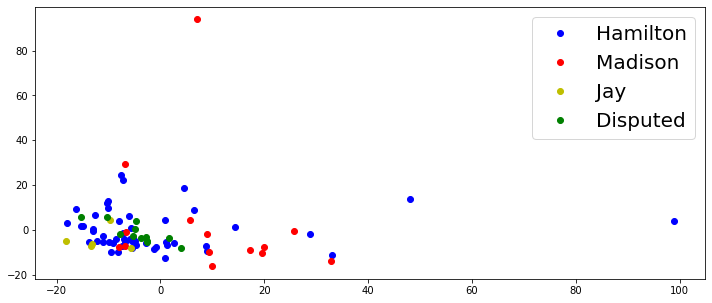

In [61]:
plt.figure(figsize=(12,5))
plt.plot(X_train_dtm_reduced[y_train=='Hamilton',0],X_train_dtm_reduced[y_train=='Hamilton',1],'bo', label='Hamilton')
plt.plot(X_train_dtm_reduced[y_train=='Madison',0],X_train_dtm_reduced[y_train=='Madison',1],'ro', label='Madison')
plt.plot(X_train_dtm_reduced[y_train=='Jay',0],X_train_dtm_reduced[y_train=='Jay',1],'yo', label='Jay')
plt.plot(X_test_dtm_reduced[:,0],X_test_dtm_reduced[:,1],'go', label='Disputed')
plt.legend(fontsize=20)

**3d visualization**

In [62]:
pca = PCA(n_components=3)

In [63]:
pca.fit(X_train_dtm.toarray())
X_train_dtm_reduced = pca.transform(X_train_dtm.toarray())

In [64]:
X_train_dtm_reduced.shape

(70, 3)

In [65]:
X_test_dtm_reduced = pca.transform(X_test_dtm.toarray())

<IPython.core.display.Javascript object>


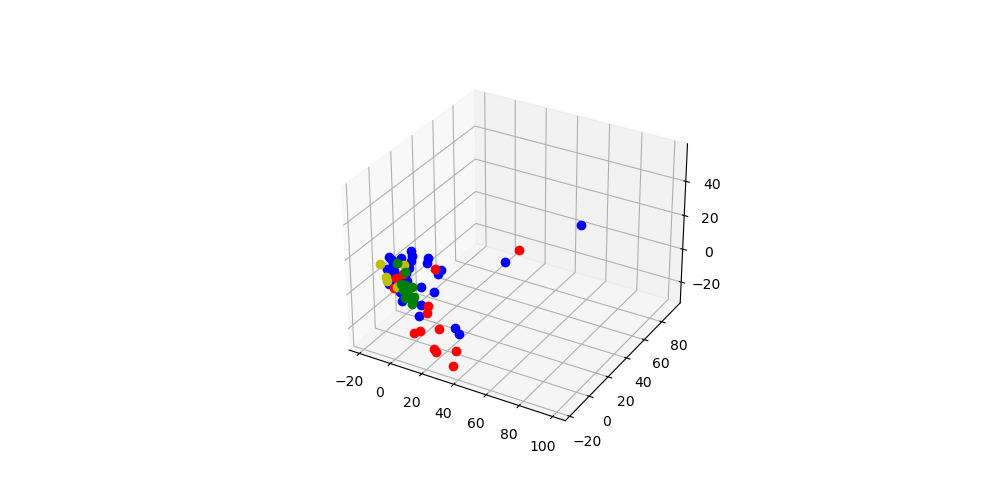

In [66]:
# 3d plot
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.axes(projection='3d')
plt.plot(X_train_dtm_reduced[y_train=='Hamilton',0],X_train_dtm_reduced[y_train=='Hamilton',1],X_train_dtm_reduced[y_train=='Hamilton',2],'bo')
plt.plot(X_train_dtm_reduced[y_train=='Madison',0],X_train_dtm_reduced[y_train=='Madison',1],X_train_dtm_reduced[y_train=='Madison',2],'ro')
plt.plot(X_train_dtm_reduced[y_train=='Jay',0],X_train_dtm_reduced[y_train=='Jay',1],X_train_dtm_reduced[y_train=='Jay',2],'yo')
plt.plot(X_test_dtm_reduced[:,0],X_test_dtm_reduced[:,1],X_test_dtm_reduced[:,2],'go')